# **A. Vectorization Of Data**

## **1. Loading the Data**

In [111]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns

# --- Configuration ---
# The only file you need to provide
original_dataset_path = '/content/drive/MyDrive/AML/vectorization/data1.csv'

# --- 1. Load Original Dataset ---
print("--- Step 1: Loading Original Dataset ---")
try:
    df_original = pd.read_csv(original_dataset_path)
    print(f"✅ Successfully loaded '{original_dataset_path}' with {len(df_original)} rows.\n")
except FileNotFoundError:
    print(f"🚨 Error: The file '{original_dataset_path}' was not found. Please make sure it's in the correct directory.")
    exit()

--- Step 1: Loading Original Dataset ---
✅ Successfully loaded '/content/drive/MyDrive/AML/vectorization/data1.csv' with 369 rows.



## **2. Verification Step**

In [112]:
# --- 2. Verification Step ---
# ==============================================================================
print("--- Step 2: Verification ---")
print("Checking for invalid chemical symbols in the 'composition' column...")

# Define the complete list of valid chemical elements
valid_elements = {
    'H', 'He', 'Li', 'Be', 'B', 'C', 'N', 'O', 'F', 'Ne', 'Na', 'Mg', 'Al', 'Si',
    'P', 'S', 'Cl', 'Ar', 'K', 'Ca', 'Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni',
    'Cu', 'Zn', 'Ga', 'Ge', 'As', 'Se', 'Br', 'Kr', 'Rb', 'Sr', 'Y', 'Zr', 'Nb',
    'Mo', 'Tc', 'Ru', 'Rh', 'Pd', 'Ag', 'Cd', 'In', 'Sn', 'Sb', 'Te', 'I', 'Xe',
    'Cs', 'Ba', 'La', 'Ce', 'Pr', 'Nd', 'Pm', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho',
    'Er', 'Tm', 'Yb', 'Lu', 'Hf', 'Ta', 'W', 'Re', 'Os', 'Ir', 'Pt', 'Au', 'Hg',
    'Tl', 'Pb', 'Bi', 'Po', 'At', 'Rn', 'Fr', 'Ra', 'Ac', 'Th', 'Pa', 'U', 'Np',
    'Pu', 'Am', 'Cm', 'Bk', 'Cf', 'Es', 'Fm', 'Md', 'No', 'Lr', 'Rf', 'Db', 'Sg',
    'Bh', 'Hs', 'Mt', 'Ds', 'Rg', 'Cn', 'Nh', 'Fl', 'Mc', 'Lv', 'Ts', 'Og'
}

# A robust function to parse all potential symbols from a formula
def get_all_symbols(formula):
    cleaned_formula = re.sub(r'[\(\)\[\]\:\+\-]|delta', ' ', formula)
    return set(re.findall(r'[A-Z][a-z]*', cleaned_formula))

# Find and report on invalid symbols
invalid_symbols_found = set()
problematic_rows_dict = {}

for index, row in df_original.iterrows():
    formula = row['composition']
    parsed_symbols = get_all_symbols(formula)
    current_invalids = parsed_symbols - valid_elements

    if current_invalids:
        invalid_symbols_found.update(current_invalids)
        for invalid_sym in current_invalids:
            if invalid_sym not in problematic_rows_dict:
                problematic_rows_dict[invalid_sym] = []
            problematic_rows_dict[invalid_sym].append(formula)

# Print the verification report
if not invalid_symbols_found:
    print("✅ Verification Complete: All element symbols found are valid.\n")
else:
    print(f"🚨 Verification Complete: Found {len(invalid_symbols_found)} invalid symbols: {sorted(list(invalid_symbols_found))}")
    for symbol in sorted(list(invalid_symbols_found)):
        formulas = problematic_rows_dict[symbol]
        print(f"\n   - Symbol '{symbol}' found in compositions like: '{formulas[0]}'")
    print("\n   These symbols will be ignored in the cleaning and vectorization step.\n")


--- Step 2: Verification ---
Checking for invalid chemical symbols in the 'composition' column...
🚨 Verification Complete: Found 9 invalid symbols: ['Alx', 'Cax', 'Cex', 'E', 'Gax', 'Nix', 'Ox', 'Oy', 'T']

   - Symbol 'Alx' found in compositions like: '(Zn1/6Ba1/6Ca1/6Sr1/6La1/3)Ti1-xAlxO3'

   - Symbol 'Cax' found in compositions like: '(Gd0.2La0.2Nd0.2Sm0.2Y0.2)(1-x)CaxFeO3'

   - Symbol 'Cex' found in compositions like: 'Er2(Y0.2Yb0.2Nb0.2Ta0.2Cex)2O'

   - Symbol 'E' found in compositions like: 'Ce-HEO'

   - Symbol 'Gax' found in compositions like: '(CoCuNiFeZn)(1-x)GaxWO4'

   - Symbol 'Nix' found in compositions like: '(NixAlCoCrMn)3O4'

   - Symbol 'Ox' found in compositions like: 'Co3MnNiCuZnOx'

   - Symbol 'Oy' found in compositions like: 'Li0.5Ni0.1Mn0.6Co0.1Al0.1Fe0.1Oy'

   - Symbol 'T' found in compositions like: 'BNT-SBT-0.3BNCBSTN'

   These symbols will be ignored in the cleaning and vectorization step.



## **3. Cleaning & 4. Vectorization Step**

In [113]:
# ==============================================================================
# --- 3. Cleaning & 4. Vectorization Step ---
# ==============================================================================
print("--- Steps 3 & 4: Cleaning and Vectorization ---")

# This single, robust function performs both cleaning (by ignoring invalid symbols) and vectorization.

def clean_and_vectorize(df):

    # --- Part A: Vectorize Chemical Compositions ---
    print("   - Vectorizing chemical compositions...")

    # Discover all unique VALID elements to use as features
    all_valid_elements_in_data = set()
    for formula in df['composition']:
        potential_elements = get_all_symbols(formula)
        for elem in potential_elements:
            if elem in valid_elements:
                all_valid_elements_in_data.add(elem)

    sorted_elements = sorted(list(all_valid_elements_in_data))

    # Calculate atomic fractions for each valid element
    vectorized_data = []
    for formula in df['composition']:
        features = {elem: 0.0 for elem in sorted_elements}
        cleaned_formula = re.sub(r'[\(\)\[\]\:\+\-]|delta', ' ', formula)
        parts = re.findall(r'([A-Z][a-z]*)(\d*\.?\d*)', cleaned_formula)

        parsed_elements = {}
        for element, number_str in parts:
            if element in valid_elements:
                number = float(number_str) if number_str else 1.0
                parsed_elements[element] = parsed_elements.get(element, 0) + number

        total_atoms = sum(parsed_elements.values())
        if total_atoms > 0:
            for element, number in parsed_elements.items():
                features[element] = number / total_atoms
        vectorized_data.append(features)

    df_composition_features = pd.DataFrame(vectorized_data)
    print("     - Done.")

    # --- Part B: One-Hot Encode Categorical Features ---
    print("   - One-hot encoding 'phase' and 'synthesis_method'...")
    df_categorical_features = pd.get_dummies(df[['phase', 'synthesis_method']], dtype=int)
    print("     - Done.")

    # --- Part C: Combine into a single DataFrame ---
    print("   - Combining all features...")
    df_final = pd.concat([df_categorical_features, df_composition_features], axis=1)
    print("     - Done.\n")

    return df_final

# Run the combined cleaning and vectorization function
df_vectorized = clean_and_vectorize(df_original)

--- Steps 3 & 4: Cleaning and Vectorization ---
   - Vectorizing chemical compositions...
     - Done.
   - One-hot encoding 'phase' and 'synthesis_method'...
     - Done.
   - Combining all features...
     - Done.



## **5. Post-Processing: Arrange Element Columns**

In [114]:
# ==============================================================================
# --- 5. Post-Processing: Arrange Element Columns ---
# ==============================================================================
print("--- Final Step: Arranging Columns by Atomic Number ---")

atomic_number_map = {
    'H': 1, 'He': 2, 'Li': 3, 'Be': 4, 'B': 5, 'C': 6, 'N': 7, 'O': 8, 'F': 9, 'Ne': 10,
    'Na': 11, 'Mg': 12, 'Al': 13, 'Si': 14, 'P': 15, 'S': 16, 'Cl': 17, 'Ar': 18, 'K': 19, 'Ca': 20,
    'Sc': 21, 'Ti': 22, 'V': 23, 'Cr': 24, 'Mn': 25, 'Fe': 26, 'Co': 27, 'Ni': 28, 'Cu': 29, 'Zn': 30,
    'Ga': 31, 'Ge': 32, 'As': 33, 'Se': 34, 'Br': 35, 'Kr': 36, 'Rb': 37, 'Sr': 38, 'Y': 39, 'Zr': 40,
    'Nb': 41, 'Mo': 42, 'Tc': 43, 'Ru': 44, 'Rh': 45, 'Pd': 46, 'Ag': 47, 'Cd': 48, 'In': 49, 'Sn': 50,
    'Sb': 51, 'Te': 52, 'I': 53, 'Xe': 54, 'Cs': 55, 'Ba': 56, 'La': 57, 'Ce': 58, 'Pr': 59, 'Nd': 60,
    'Pm': 61, 'Sm': 62, 'Eu': 63, 'Gd': 64, 'Tb': 65, 'Dy': 66, 'Ho': 67, 'Er': 68, 'Tm': 69, 'Yb': 70,
    'Lu': 71, 'Hf': 72, 'Ta': 73, 'W': 74, 'Re': 75, 'Os': 76, 'Ir': 77, 'Pt': 78, 'Au': 79, 'Hg': 80,
    'Tl': 81, 'Pb': 82, 'Bi': 83, 'Po': 84, 'At': 85, 'Rn': 86, 'Fr': 87, 'Ra': 88, 'Ac': 89, 'Th': 90,
    'Pa': 91, 'U': 92, 'Np': 93, 'Pu': 94, 'Am': 95, 'Cm': 96, 'Bk': 97, 'Cf': 98, 'Es': 99, 'Fm': 100,
    'Md': 101, 'No': 102, 'Lr': 103, 'Rf': 104, 'Db': 105, 'Sg': 106, 'Bh': 107, 'Hs': 108, 'Mt': 109,
    'Ds': 110, 'Rg': 111, 'Cn': 112, 'Nh': 113, 'Fl': 114, 'Mc': 115, 'Lv': 116, 'Ts': 117, 'Og': 118
}

categorical_cols = [col for col in df_vectorized.columns if 'phase_' in col or 'synthesis_' in col]
element_cols = [col for col in df_vectorized.columns if col not in categorical_cols]
sorted_element_cols = sorted(element_cols, key=lambda x: atomic_number_map.get(x, 999))

final_ordered_columns = categorical_cols + sorted_element_cols
df_final_clean = df_vectorized[final_ordered_columns]

print("✅ All steps are complete.\n")
print("--- FINAL CLEAN DATA ---")
print(df_final_clean.head())

print("\nColumn order:")
print(df_final_clean.columns.tolist())

--- Final Step: Arranging Columns by Atomic Number ---
✅ All steps are complete.

--- FINAL CLEAN DATA ---
   phase_O3-type layered  phase_amorphous  phase_bixbyite  \
0                      0                0               0   
1                      0                0               0   
2                      0                0               0   
3                      0                0               0   
4                      0                0               0   

   phase_cubic perovskite  phase_double perovskite  phase_fluorite  \
0                       0                        0               1   
1                       0                        0               1   
2                       0                        0               1   
3                       0                        0               1   
4                       0                        0               1   

   phase_magnetoplumbite  phase_monoclinic  phase_multiphase  \
0                      0                 

In [115]:
df_final_clean.head(10)

,phase_O3-type layered,phase_amorphous,phase_bixbyite,phase_cubic perovskite,phase_double perovskite,phase_fluorite,phase_magnetoplumbite,phase_monoclinic,phase_multiphase,phase_orthorhombic perovskite,...,Er,Tm,Yb,Lu,Hf,Ta,W,Ir,Pb,Bi
0,0,0,0,0,0,1,0,0,0,0,...,0.0,0.0,0.041667,0.0,0.083333,0.0,0.0,0.0,0.0,0.0
1,0,0,0,0,0,1,0,0,0,0,...,0.0,0.0,0.066667,0.0,0.066667,0.0,0.0,0.0,0.0,0.0
2,0,0,0,0,0,1,0,0,0,0,...,0.0,0.0,0.000000,0.0,0.083333,0.0,0.0,0.0,0.0,0.0
3,0,0,0,0,0,1,0,0,0,0,...,0.0,0.0,0.000000,0.0,0.083333,0.0,0.0,0.0,0.0,0.0
4,0,0,0,0,0,1,0,0,0,0,...,0.0,0.0,0.000000,0.0,0.066667,0.0,0.0,0.0,0.0,0.0
5,0,0,0,0,0,1,0,0,0,0,...,0.0,0.0,0.041667,0.0,0.083333,0.0,0.0,0.0,0.0,0.0
6,0,0,0,0,0,1,0,0,0,0,...,0.0,0.0,0.066667,0.0,0.066667,0.0,0.0,0.0,0.0,0.0
7,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
8,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
9,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


### **Summary:**
**1. Verification:** We first inspected the original dataset by programmatically parsing all chemical compositions. This was done to automatically identify any symbols that were not valid chemical elements.

**2. Cleaning:** We then developed an intelligent cleaning process that specifically ignores the invalid symbols found during verification. This automatically filtered out non-element notations like Cex and Ox, ensuring data quality.

**3. Vectorization:** Next, we converted the clean data into a fully numerical format suitable for machine learning. This involved calculating the atomic fraction for each valid element and transforming the categorical text columns into binary (0/1) features.

**4. Final Arrangement:** As a final step, we organized the element columns in the dataset by sorting them based on their atomic number. This arranged the features in the logical and scientifically meaningful order of the periodic table.

In [116]:

# Define the filename for your final dataset
output_filename = '/content/drive/MyDrive/AML/vectorization/Vectorized_dataset.csv'

# Save the DataFrame to a CSV file
# index=False prevents pandas from writing the row numbers into the file
df_final_clean.to_csv(output_filename, index=False)

print(f"✅ Successfully saved the final data to the file: '{output_filename}'")
print("You can now find and download this file from your project directory.")

✅ Successfully saved the final data to the file: '/content/drive/MyDrive/AML/vectorization/Vectorized_dataset.csv'
You can now find and download this file from your project directory.


# **B. Analysis Of Vectorized Data**

## **1. Analyzing phase and synthesis method distributions**

### Subtask:
Create bar plots to show the counts of different phases and synthesis methods, identifying the most common categories.


**Reasoning**:
Create bar plots to visualize the distribution of phases and synthesis methods as requested by the instructions.



/tmp/ipython-input-739707192.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




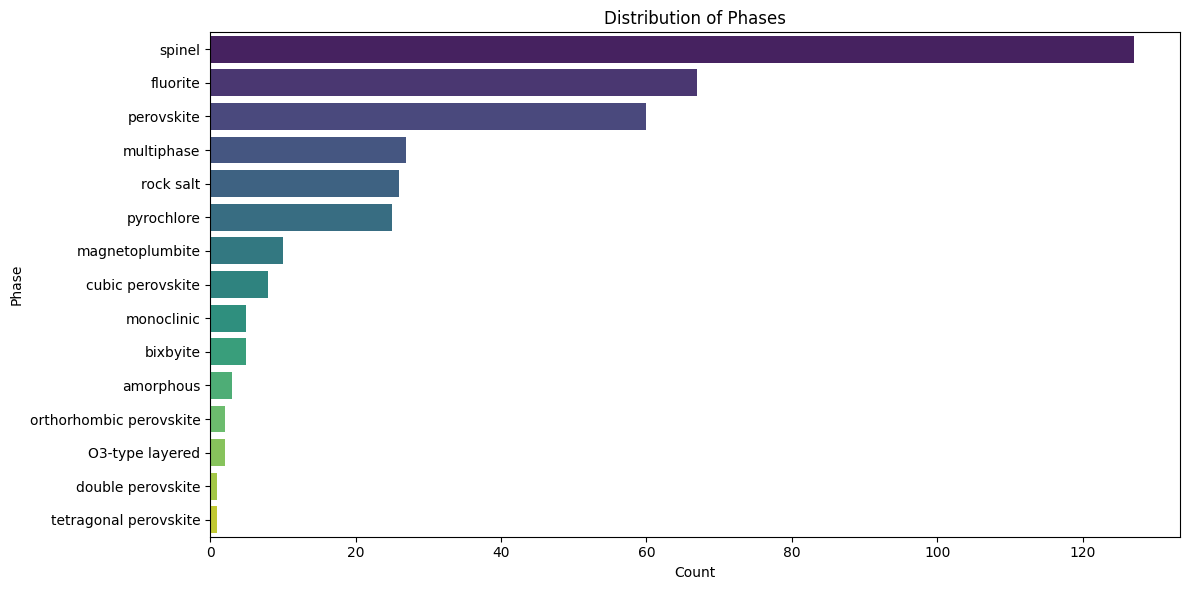

/tmp/ipython-input-739707192.py:12: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




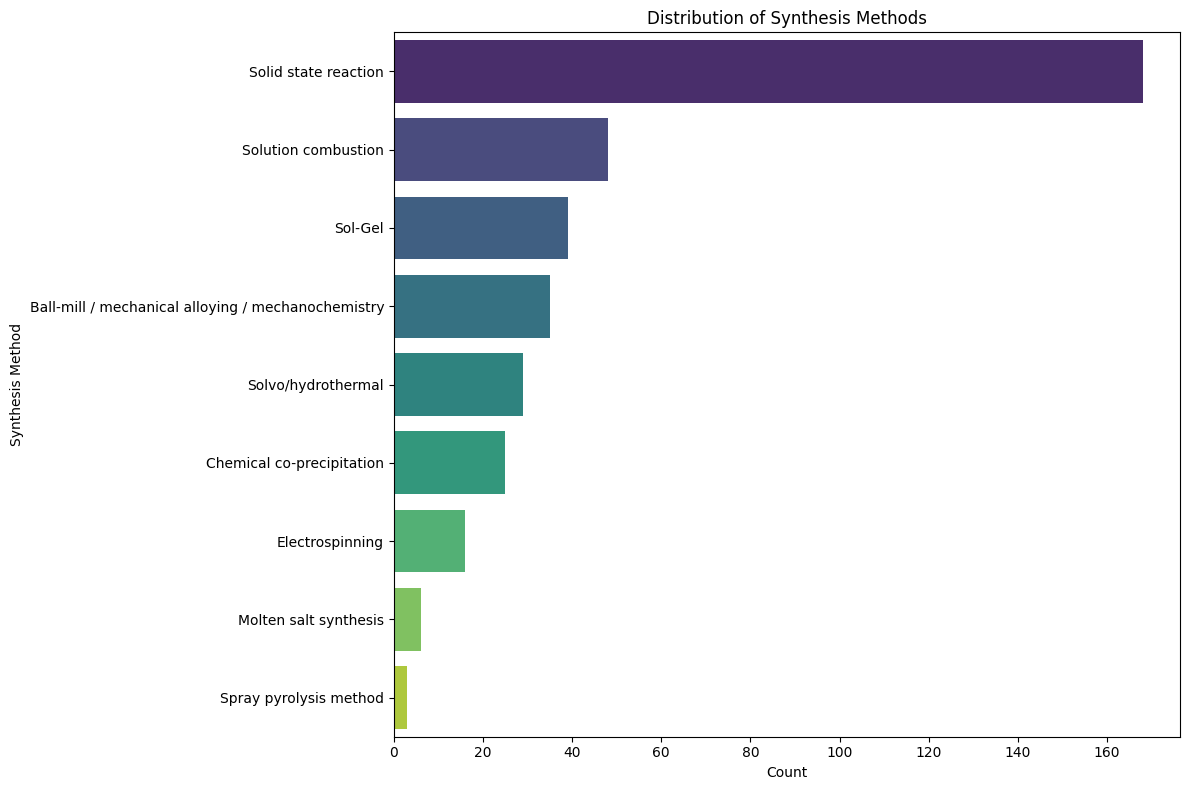

In [117]:
# Create a bar plot for phase distribution
plt.figure(figsize=(12, 6))
sns.countplot(data=df_original, y='phase', order=df_original['phase'].value_counts().index, palette='viridis')
plt.xlabel('Count')
plt.ylabel('Phase')
plt.title('Distribution of Phases')
plt.tight_layout()
plt.show()

# Create a bar plot for synthesis method distribution
plt.figure(figsize=(12, 8))
sns.countplot(data=df_original, y='synthesis_method', order=df_original['synthesis_method'].value_counts().index, palette='viridis')
plt.xlabel('Count')
plt.ylabel('Synthesis Method')
plt.title('Distribution of Synthesis Methods')
plt.tight_layout()
plt.show()

### **2. Perform correlation analysis**

### Subtask:
Calculate and visualize the correlation matrix of the element features to identify any strong correlations between them.


**Reasoning**:
Isolate the element columns and calculate the correlation matrix.



In [118]:
# Isolate element columns
categorical_cols = [col for col in df_final_clean.columns if 'phase_' in col or 'synthesis_' in col]
element_cols = [col for col in df_final_clean.columns if col not in categorical_cols]
df_elements = df_final_clean[element_cols]

# Calculate the correlation matrix
correlation_matrix = df_elements.corr()

**Reasoning**:
Create a heatmap of the correlation matrix to visualize the correlations between element features.



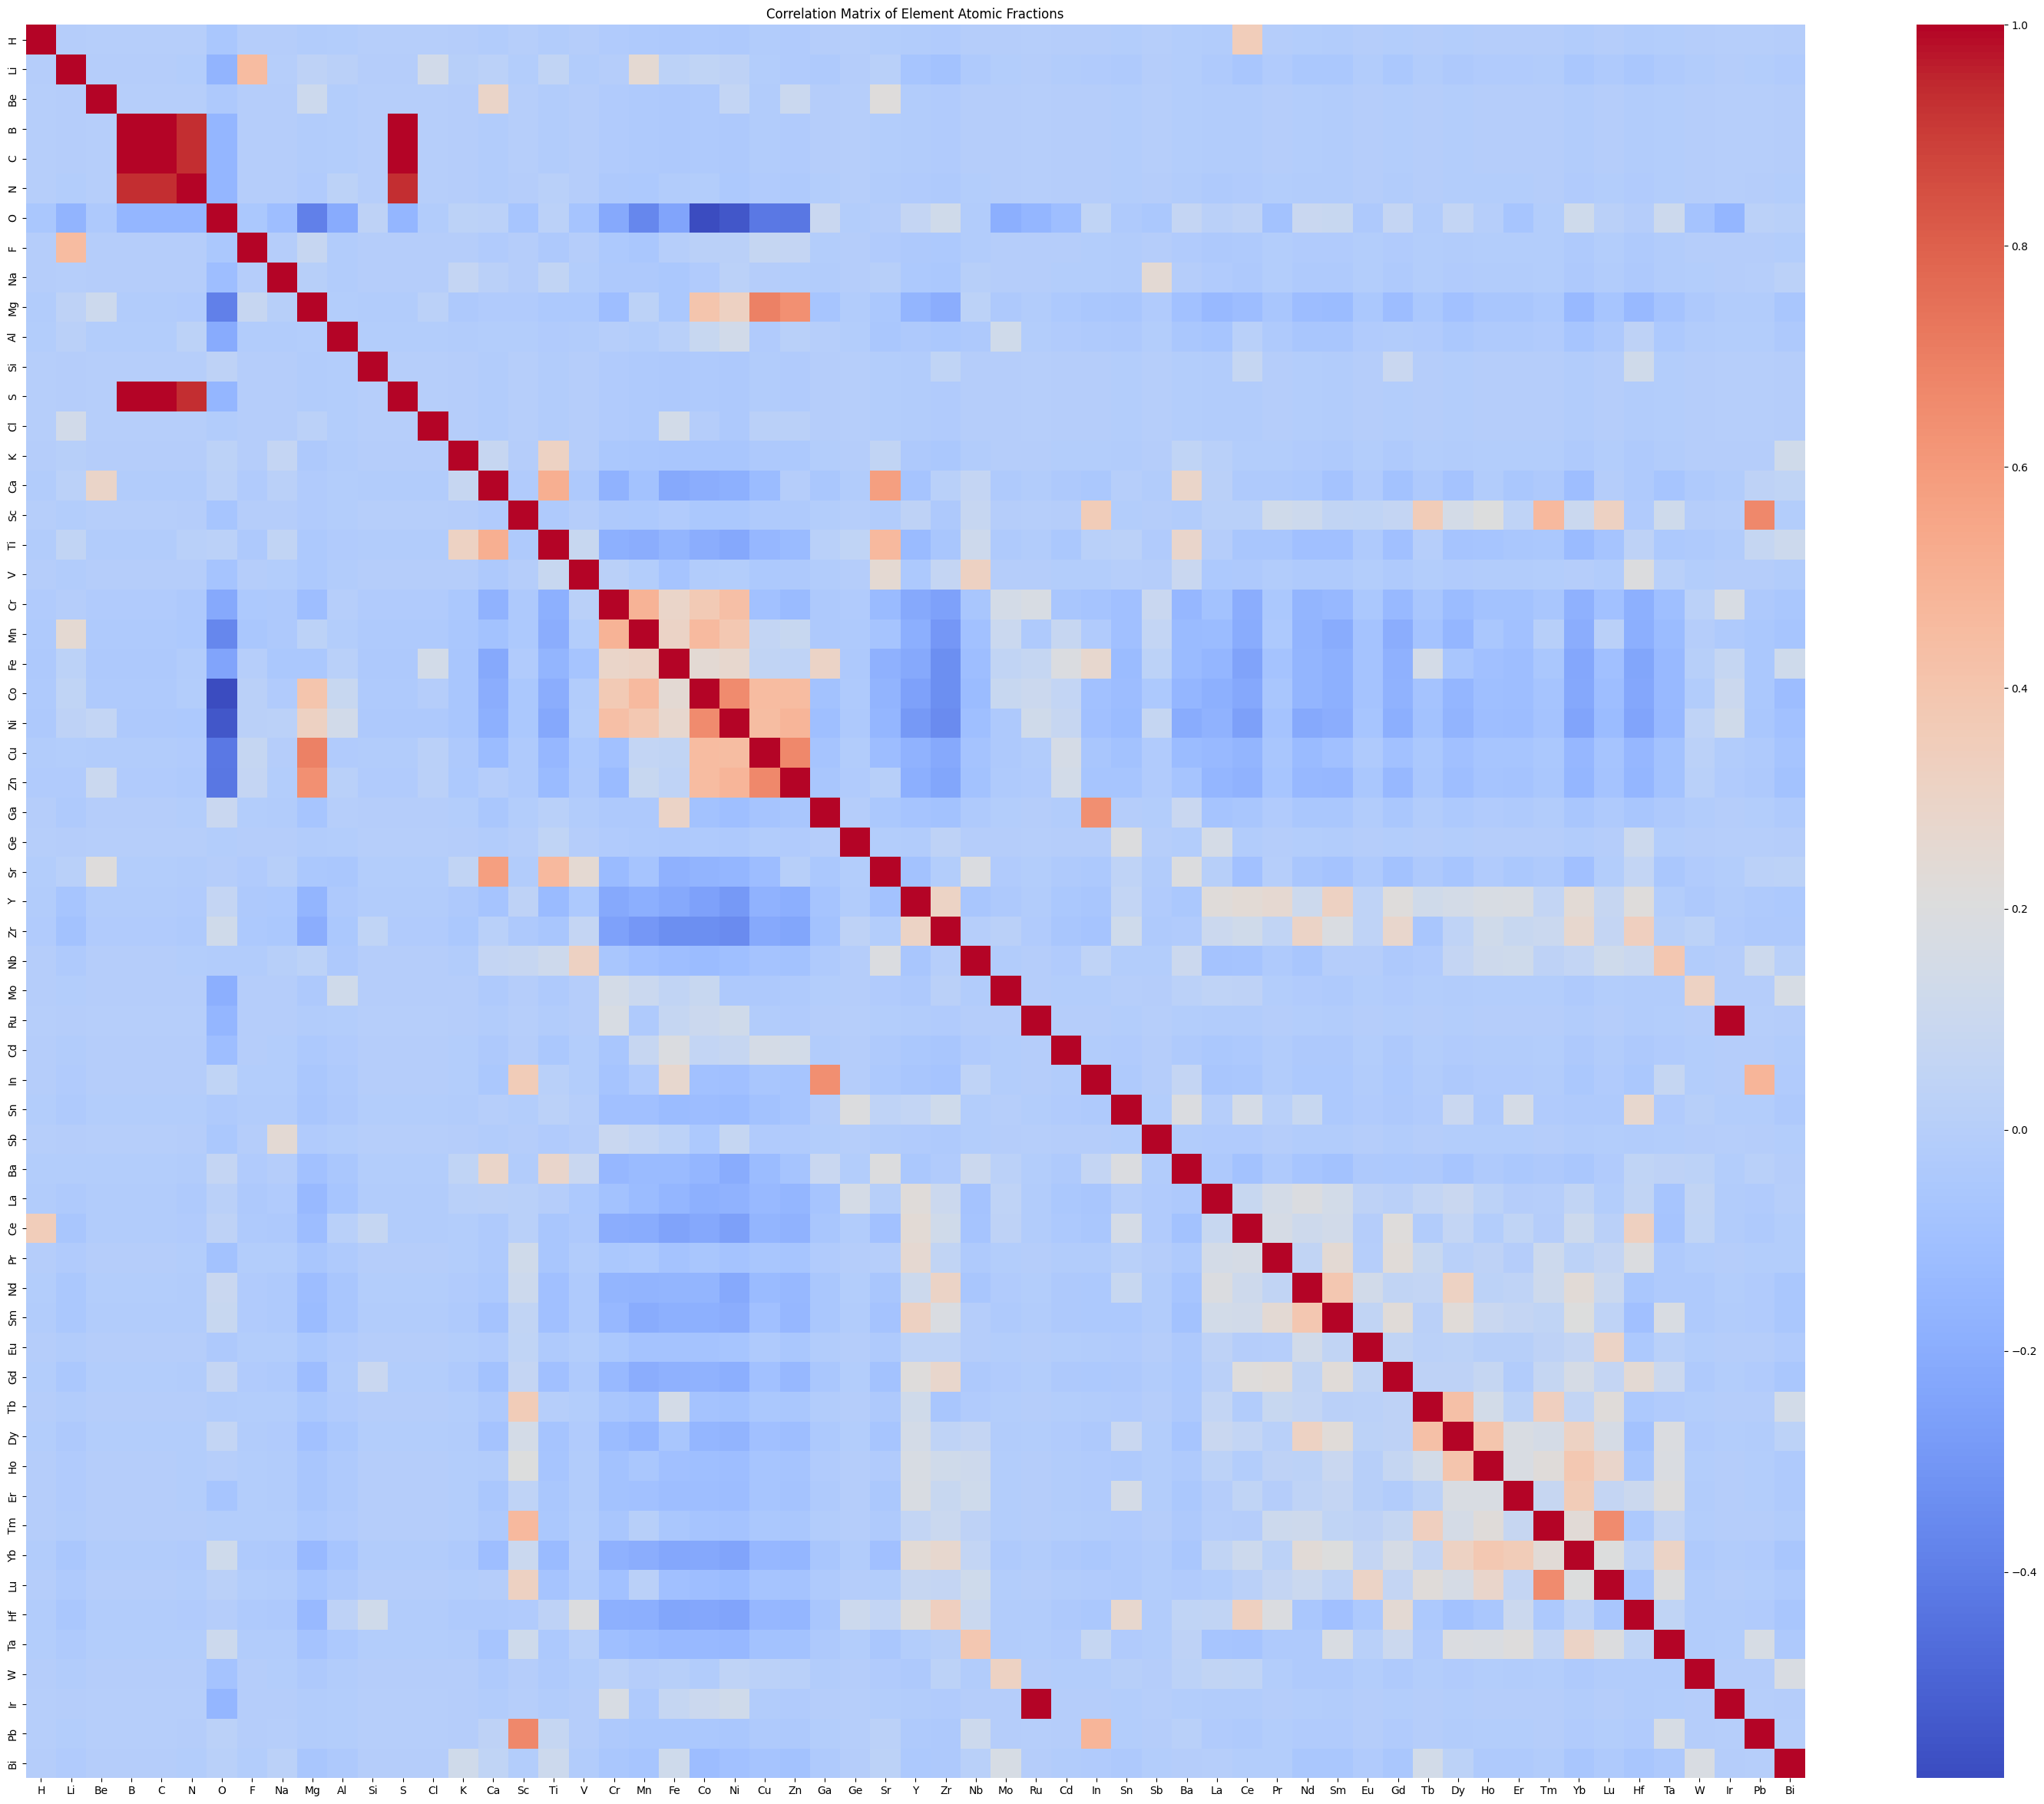

In [119]:
# Determine the size of the heatmap based on the number of elements
num_elements = len(element_cols)
figsize = (max(10, num_elements * 0.5), max(8, num_elements * 0.4))

# Create the heatmap
plt.figure(figsize=figsize)
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False) # Annotations are turned off for large matrices
plt.title('Correlation Matrix of Element Atomic Fractions')
plt.tight_layout()
plt.show()

# **C. Clustering Analysis**

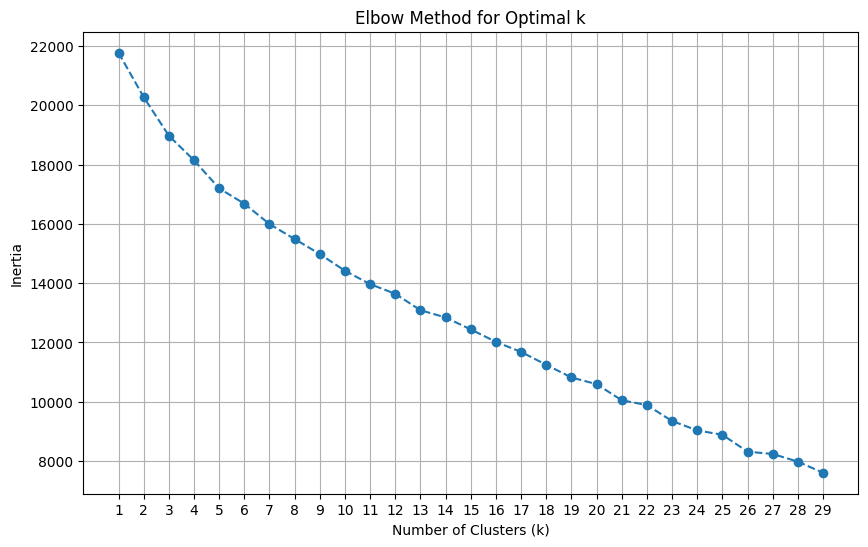

In [120]:
import matplotlib.pyplot as plt

# Use the scaled data from the previous step
inertia = []
k_range = range(1, 30)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.xticks(k_range)
plt.grid(True)
plt.show()

## **3. Try More Advanced Clustering Algorithms**

In [125]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import pandas as pd

# Load your final, ordered dataset and original labels
df = pd.read_csv('/content/drive/MyDrive/AML/vectorization/Vectorized_dataset.csv')
df_original = pd.read_csv('/content/drive/MyDrive/AML/vectorization/data1.csv')

# Isolate element features and apply scaling
element_cols = [col for col in df.columns if 'phase_' not in col and 'synthesis_' not in col]
X_elements = df[element_cols]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_elements)

# --- Run the final analysis with k=5 ---
kmeans_final = KMeans(n_clusters=5, random_state=42, n_init=10)
kmeans_final.fit(X_scaled)

# Analyze the final, most distinct clusters
df_original['cluster_final'] = kmeans_final.labels_
final_crosstab = pd.crosstab(df_original['cluster_final'], df_original['phase'])

print("--- Final Clustering Results (k=5 on Scaled Data) ---")
print(final_crosstab)

--- Final Clustering Results (k=5 on Scaled Data) ---
phase          O3-type layered  amorphous  bixbyite  cubic perovskite  \
cluster_final                                                           
0                            0          0         0                 8   
1                            0          1         0                 0   
2                            0          0         0                 0   
3                            0          0         5                 0   
4                            2          2         0                 0   

phase          double perovskite  fluorite  magnetoplumbite  monoclinic  \
cluster_final                                                             
0                              0         1                0           0   
1                              0         0                0           1   
2                              0         0                0           0   
3                              0        66                0

# **D. Applying Machine Learning Models**

## **1. Define the "Super-Family" Labels**

Based on your final clustering results, we can define a clear mapping from the original phase to a new "super-family" label.

**Cluster 0** -> Perovskite Family: Dominated by all types of perovskites.

**Cluster 3** -> Fluorite Family: Dominated by fluorite, pyrochlore, and bixbyite.

**Cluster 4** -> Spinel Family: Dominated by spinels and magnetoplumbite.

**Cluster 1** -> Rock Salt / Other Family: Contains rock salt and a mix of other phases.

**Cluster 2** -> Minor Phases: A very small, distinct group.

## **2. Running the Four Predictive Models with New Labels**

Error: The file 'dataset_HEO_filtered_with_synthesis_clean.xlsx - Sheet1.csv' was not found.


/tmp/ipython-input-1047865148.py:48: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




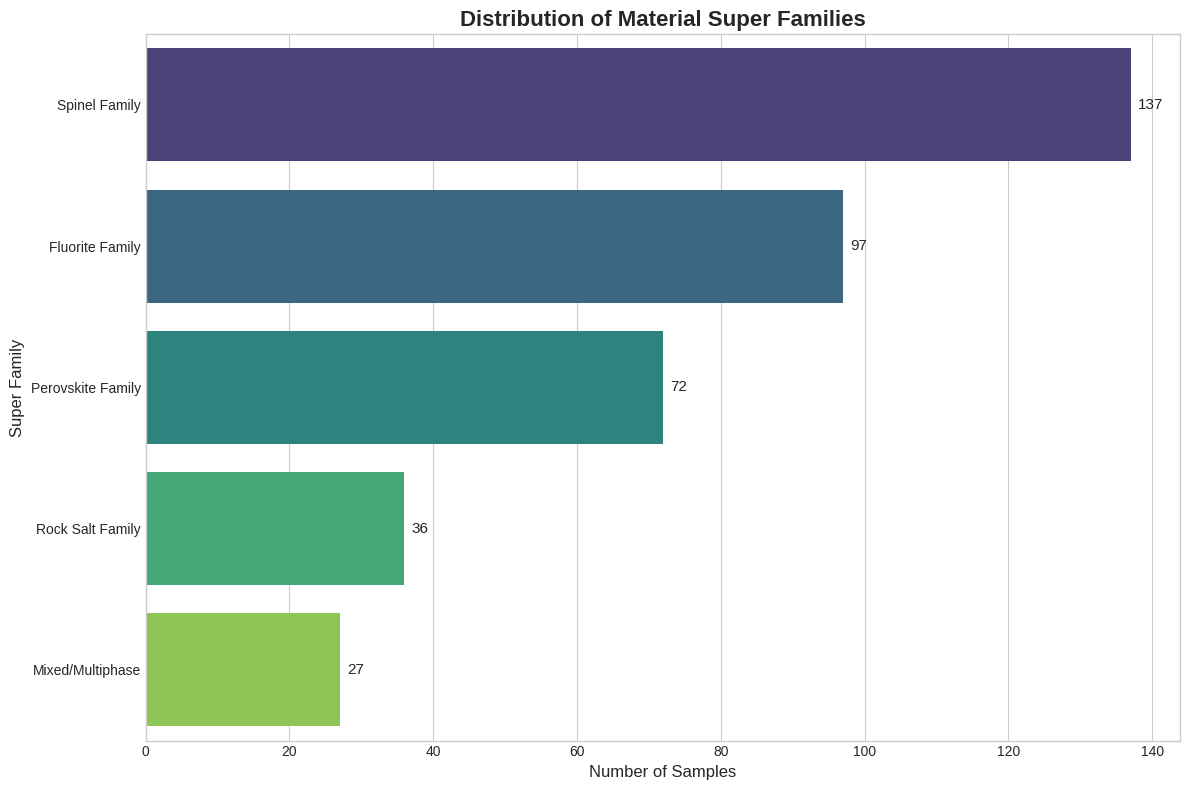

In [135]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Step 1: Load the Original Dataset ---
# We only need the original file to get the 'phase' column.
try:
    df_original = pd.read_csv('dataset_HEO_filtered_with_synthesis_clean.xlsx - Sheet1.csv')
except FileNotFoundError:
    print("Error: The file 'dataset_HEO_filtered_with_synthesis_clean.xlsx - Sheet1.csv' was not found.")
    exit()

# --- Step 2: Define the Super-Family Mapping ---
# This is the same mapping we derived from our clustering analysis.
phase_to_family_map = {
    'perovskite': 'Perovskite Family',
    'cubic perovskite': 'Perovskite Family',
    'orthorhombic perovskite': 'Perovskite Family',
    'tetragonal perovskite': 'Perovskite Family',
    'double perovskite': 'Perovskite Family',

    'fluorite': 'Fluorite Family',
    'pyrochlore': 'Fluorite Family',
    'bixbyite': 'Fluorite Family',

    'spinel': 'Spinel Family',
    'magnetoplumbite': 'Spinel Family',

    'rock salt': 'Rock Salt Family',
    'O3-type layered': 'Rock Salt Family',
    'amorphous': 'Rock Salt Family',
    'monoclinic': 'Rock Salt Family',

    'multiphase': 'Mixed/Multiphase'
}

# --- Step 3: Create the Super-Family Column ---
# We apply the mapping to the original 'phase' column.
# .get(x, 'Mixed/Multiphase') ensures any phase not in the map is handled gracefully.
df_original['super_family'] = df_original['phase'].apply(lambda x: phase_to_family_map.get(x, 'Mixed/Multiphase'))

# --- Step 4: Create the Bar Plot ---
plt.style.use('seaborn-v0_8-whitegrid') # Use a nice style for the plot
plt.figure(figsize=(12, 8)) # Set the figure size for better readability

# Create the countplot using seaborn
# The 'order' argument sorts the bars from most frequent to least frequent
ax = sns.countplot(y='super_family',
                   data=df_original,
                   order=df_original['super_family'].value_counts().index,
                   palette='viridis')

# --- Step 5: Customize and Show the Plot ---
ax.set_title('Distribution of Material Super Families', fontsize=16, fontweight='bold')
ax.set_xlabel('Number of Samples', fontsize=12)
ax.set_ylabel('Super Family', fontsize=12)
ax.tick_params(axis='x', labelsize=10)
ax.tick_params(axis='y', labelsize=10)

# Add count labels to the end of each bar for clarity
for p in ax.patches:
    width = p.get_width()
    plt.text(width + 1,  # Position of the text
             p.get_y() + p.get_height() / 2,
             f'{int(width)}', # The text to display (the count)
             va='center',
             ha='left',
             fontsize=11)

plt.tight_layout()
plt.show()


In [134]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report

# Import the models we want to test
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

# --- Step 1: Prepare the Data ---
df_vectorized = pd.read_csv('/content/drive/MyDrive/AML/vectorization/Vectorized_dataset.csv')
df_original = pd.read_csv('/content/drive/MyDrive/AML/vectorization/data1.csv')

# Create the "Super-Family" labels
phase_to_family_map = {
    'perovskite': 'Perovskite_Family', 'cubic perovskite': 'Perovskite_Family',
    'orthorhombic perovskite': 'Perovskite_Family', 'tetragonal perovskite': 'Perovskite_Family',
    'double perovskite': 'Perovskite_Family', 'fluorite': 'Fluorite_Family',
    'pyrochlore': 'Fluorite_Family', 'bixbyite': 'Fluorite_Family',
    'spinel': 'Spinel_Family', 'magnetoplumbite': 'Spinel_Family',
    'rock salt': 'Rock_Salt_Family', 'O3-type layered': 'Rock_Salt_Family',
    'amorphous': 'Rock_Salt_Family', 'monoclinic': 'Rock_Salt_Family',
    'multiphase': 'Mixed_Or_Multiphase'
}
y_super_family = df_original['phase'].apply(lambda x: phase_to_family_map.get(x, 'Mixed_Or_Multiphase'))

# Define features (X) and scale them
element_cols = [col for col in df_vectorized.columns if 'phase_' not in col and 'synthesis_' not in col]
X = df_vectorized[element_cols]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Encode text labels into integers for models like XGBoost and MLP
le = LabelEncoder()
y_encoded = le.fit_transform(y_super_family)

# Split the data
X_train, X_test, y_train_encoded, y_test_encoded = train_test_split(
    X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)
# We still need the original text labels for the final report
_, _, _, y_test_text = train_test_split(
    X_scaled, y_super_family, test_size=0.2, random_state=42, stratify=y_super_family
)


# --- Step 2: Define and Test All Models ---
models = {
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=1000),
    "Support Vector Machine": SVC(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss'),
    "Neural Network (MLP)": MLPClassifier(random_state=42, max_iter=1000)
}

# Loop through each model to train and evaluate it
for name, model in models.items():
    print(f"--- Testing Model: {name} ---")

    # Train the model on the encoded training labels
    model.fit(X_train, y_train_encoded)

    # Make predictions and evaluate
    y_pred_encoded = model.predict(X_test)
    accuracy = accuracy_score(y_test_encoded, y_pred_encoded)

    # For the report, we use the original TEXT labels to make it readable
    print(f"Accuracy: {accuracy * 100:.2f}%\n")
    print("Classification Report:")
    # Use the label encoder to transform predictions back to text for the report
    print(classification_report(y_test_text, le.inverse_transform(y_pred_encoded), zero_division=0))
    print("="*60 + "\n")

--- Testing Model: Logistic Regression ---
Accuracy: 86.49%

Classification Report:
                     precision    recall  f1-score   support

    Fluorite_Family       0.95      1.00      0.98        20
Mixed_Or_Multiphase       0.67      0.40      0.50         5
  Perovskite_Family       0.80      0.86      0.83        14
   Rock_Salt_Family       0.71      0.71      0.71         7
      Spinel_Family       0.89      0.89      0.89        28

           accuracy                           0.86        74
          macro avg       0.81      0.77      0.78        74
       weighted avg       0.86      0.86      0.86        74


--- Testing Model: Support Vector Machine ---
Accuracy: 85.14%

Classification Report:
                     precision    recall  f1-score   support

    Fluorite_Family       0.87      1.00      0.93        20
Mixed_Or_Multiphase       0.00      0.00      0.00         5
  Perovskite_Family       0.75      0.86      0.80        14
   Rock_Salt_Family       0.86 

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning:

[17:18:48] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.




Accuracy: 82.43%

Classification Report:
                     precision    recall  f1-score   support

    Fluorite_Family       0.86      0.95      0.90        20
Mixed_Or_Multiphase       0.00      0.00      0.00         5
  Perovskite_Family       0.86      0.86      0.86        14
   Rock_Salt_Family       0.62      0.71      0.67         7
      Spinel_Family       0.89      0.89      0.89        28

           accuracy                           0.82        74
          macro avg       0.65      0.68      0.66        74
       weighted avg       0.79      0.82      0.81        74


--- Testing Model: Neural Network (MLP) ---
Accuracy: 86.49%

Classification Report:
                     precision    recall  f1-score   support

    Fluorite_Family       0.95      1.00      0.98        20
Mixed_Or_Multiphase       0.50      0.40      0.44         5
  Perovskite_Family       0.80      0.86      0.83        14
   Rock_Salt_Family       0.83      0.71      0.77         7
      Spinel_Fa

## **Loading the Model and Making a Prediction**

In [129]:
import joblib
import numpy as np
import pandas as pd # Needed to access X.columns

# --- 1. Load All Three Required Files ---
loaded_model = joblib.load('/content/drive/MyDrive/AML/vectorization/material_family_predictor.pkl')
loaded_scaler = joblib.load('/content/drive/MyDrive/AML/vectorization/feature_scaler.pkl')
loaded_le = joblib.load('/content/drive/MyDrive/AML/vectorization/label_encoder.pkl')

# We need the element column order from the original training data
# This is a simple way to get it
df_vectorized = pd.read_csv('/content/drive/MyDrive/AML/vectorization/Vectorized_dataset.csv')
element_cols = [col for col in df_vectorized.columns if 'phase_' not in col and 'synthesis_' not in col]


# --- 2. Create a Function to Predict a New Composition ---
def predict_new_composition(composition_dict, element_columns, scaler, model, label_encoder):
    # Create a feature vector with zeros for all elements
    features = {elem: 0.0 for elem in element_columns}

    # Update the vector with the new composition's values
    total_atoms = sum(composition_dict.values())
    for element, amount in composition_dict.items():
        if element in features:
            features[element] = amount / total_atoms

    # Convert to a numpy array in the correct order
    feature_vector = np.array([features[col] for col in element_columns]).reshape(1, -1)

    # Scale the features using the loaded scaler
    scaled_features = scaler.transform(feature_vector)

    # Make the prediction
    prediction_encoded = model.predict(scaled_features)

    # Convert the prediction from a number back to the text label
    prediction_text = label_encoder.inverse_transform(prediction_encoded)

    return prediction_text[0]

# --- 3. Example Usage ---
# Let's predict the family for a new material with high Zirconium and Yttrium content
new_material = {'Zr': 0.4, 'Y': 0.4, 'O': 0.2}
predicted_family = predict_new_composition(new_material, element_cols, loaded_scaler, loaded_model, loaded_le)

print(f"The predicted material family for {new_material} is: {predicted_family}")

The predicted material family for {'Zr': 0.4, 'Y': 0.4, 'O': 0.2} is: Fluorite_Family


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

